# Data Cleaning Notebook

This notebook contains **basic data cleaning steps that are not included in the NLP preprocessing procedure**. We will also be doing **EDA** on **non-corpus data** columns here.

The purpose of this is to fix up the provided `twitter_data.csv` and adjust it for our classification use. **The cleaned dataframe will be pickled for future use across all notebooks.**

In [67]:
# import libraries
import pandas as pd
pd.options.display.max_columns = 50
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()
plt.style.use('bmh')
import sklearn
from sklearn.preprocessing import StandardScaler, binarize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV, SelectKBest, f_regression
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, plot_confusion_matrix, roc_curve, auc, classification_report
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, GridSearchCV
import pickle

## Load in data from `twitter_data.csv` 

In [68]:
df = pd.read_csv('twitter_data.csv', index_col=0)

In [69]:
df.head()

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24783 entries, 0 to 25296
Data columns (total 6 columns):
count                 24783 non-null int64
hate_speech           24783 non-null int64
offensive_language    24783 non-null int64
neither               24783 non-null int64
class                 24783 non-null int64
tweet                 24783 non-null object
dtypes: int64(5), object(1)
memory usage: 1.3+ MB


In [71]:
df['class'].unique()

array([2, 1, 0])

## Checking Class Imbalance of Original Data's Labels

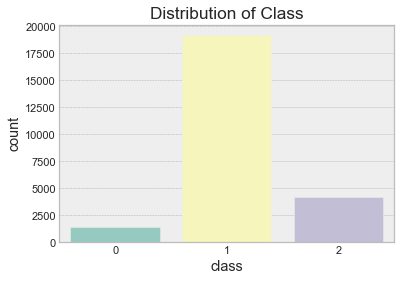

In [72]:
sns.countplot(df['class'], palette='Set3').set_title('Distribution of Class')

plt.savefig('../visualizations/orig_class_imbalance.png', bbox_inches = "tight", pad_inches=.5)

In [73]:
# df['class'].sum() / len(df['class'])

## Creating new column `label` for hate speech binary

In the original data, the `class` column identifies each tweet as 0 for hate speech, 1 for offensive language or 2 for neither. 

We will be changing offensive language to 2, and identifying that all to 0 for **not hate speech**. And changing hate specch to 1.

In [74]:
df['label'] = df['class'].replace(1, 2)

In [75]:
df.head()

,count,hate_speech,offensive_language,neither,class,tweet,label
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,2
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,2
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,2
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,2
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,2


In [76]:
df.label.unique()

array([2, 0])

In [77]:
# changing hate speech to 1 and not hate speech to 0
df['label'] = df['label'].replace(0, 1)
df['label'] = df['label'].replace(2, 0)

In [78]:
df.label.unique()

array([0, 1])

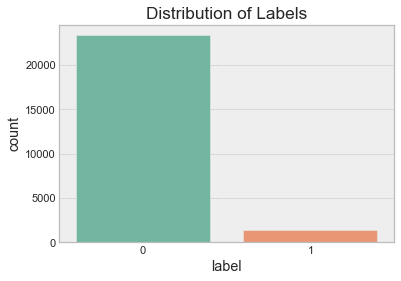

In [79]:
sns.countplot(df['label'], palette='Set2').set_title('Distribution of Labels')

plt.savefig('../visualizations/cleaned_class_imbalance.png', bbox_inches = "tight", pad_inches=.5)

In [80]:
# we can see that only 5.7% of the data is actual hate speech
df['label'].sum() / len(df['label'])

0.05770084332001776

## Creating new `clean_df` with renamed columns

Changes from original df:
- dropping the class column
- renmaing `count` to `total_votes`
- renaming `hate_speech` to `hate_speech_votes`
- adding together `offensive_language` and `neither` to become `other_votes`

In [81]:
# creating new dataframe `clean_df`
clean_df = df[['count', 'hate_speech', 'offensive_language', 'neither', 'tweet', 'label']].copy()

In [82]:
# renaming those columns
clean_df.rename(columns={'count':'total_votes', 'hate_speech': 'hate_speech_votes', }, inplace=True)

In [83]:
# creating column for vote count for not hate speech tweets
clean_df['other_votes'] = clean_df['offensive_language'] + clean_df['neither']

In [84]:
# reordering the columns and dropping the old 'offensive_language' and 'neither' columns
clean_df = clean_df.reindex(columns=['total_votes', 'hate_speech_votes', 'other_votes','label', 'tweet'])

In [85]:
# checking that it all worked
clean_df.head()

,total_votes,hate_speech_votes,other_votes,label,tweet
0,3,0,3,0,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,3,0,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


## Cleaning `tweet` column - first round

In [86]:
clean_df.head()

,total_votes,hate_speech_votes,other_votes,label,tweet
0,3,0,3,0,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,3,0,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [87]:
# function to clean all data
import re
import string

def clean_text_round1(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    # make text lowecase
    text = text.lower()
    # removing text within brackets
    text = re.sub('\[.*?\]', '', text)
    # removing text within parentheses
    text = re.sub('\(.*?\)', '', text)
    # removing numbers
    text = re.sub('\w*\d\w*', '', text)
    # if there's more than 1 whitespace, then make it just 1
    text = re.sub('\s+', ' ', text)
    # if there's a new line, then make it a whitespace
    text = re.sub('\n', ' ', text)
    # removing any quotes
    text = re.sub('\"+', '', text)
    # removing &amp;
    text = re.sub('(\&amp\;)', '', text)
    # removing any usernames
    text = re.sub('(@[^\s]+)', '', text)
    # remove `rt` for retweet
    text = re.sub('(rt)', '', text)
    # string.punctuation is a string of all punctiation marks
    # so this gets rid of all punctuation
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    # getting rid of `httptco`
    text = re.sub('(httptco)', '', text)

    return text

round1 = lambda x: clean_text_round1(x)

In [88]:
clean_df['round_1_tweet'] = clean_df['tweet'].apply(round1)

In [89]:
clean_df.head()

,total_votes,hate_speech_votes,other_votes,label,tweet,round_1_tweet
0,3,0,3,0,!!! RT @mayasolovely: As a woman you shouldn't...,as a woman you shouldnt complain about clea...
1,3,0,3,0,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,boy dats coldtyga dwn bad for cuffin dat ho...
2,3,0,3,0,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,dawg you ever fuck a bitch and she sta to...
3,3,0,3,0,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,she look like a tranny
4,6,0,6,0,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,the shit you hear about me might be true or...


In [90]:
# checking for missing values
clean_df.isnull().sum()

total_votes          0
hate_speech_votes    0
other_votes          0
label                0
tweet                0
round_1_tweet        0
dtype: int64

## Pickling `clean_df` for later use
If there needs to be further data cleaning or preprocessing, that will be done in other notebooks

In [91]:
clean_df.to_pickle("../pickle/clean_df.pkl")